## Initialization

In [1]:
pip install seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 285 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Data

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
display(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [3]:
#Checking df shape.
print(labels.shape)

(7591, 2)


In [4]:
#Checking NaNs in df.
print(labels.isna().sum())

file_name    0
real_age     0
dtype: int64


In [5]:
#Checking duplicates in df.
print(labels.duplicated().sum())

0


## EDA

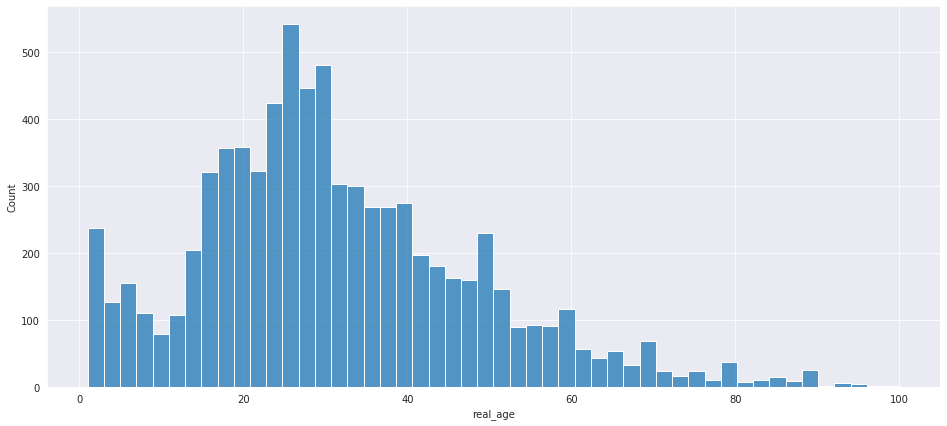

In [6]:
#Plotting an histogram of real_age column to understand age distribution in the df.
sns.set_style('darkgrid')
plt.figure(figsize=(16,7))
sns.histplot(labels['real_age'], bins = 50)
plt.show()

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

data_flow = datagen.flow_from_dataframe(
    dataframe = labels,
    directory = '/datasets/faces/final_files/',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (224,244),
    batch_size = 32,
    class_mode = 'raw',
    seed = 12345)

Found 7591 validated image filenames.


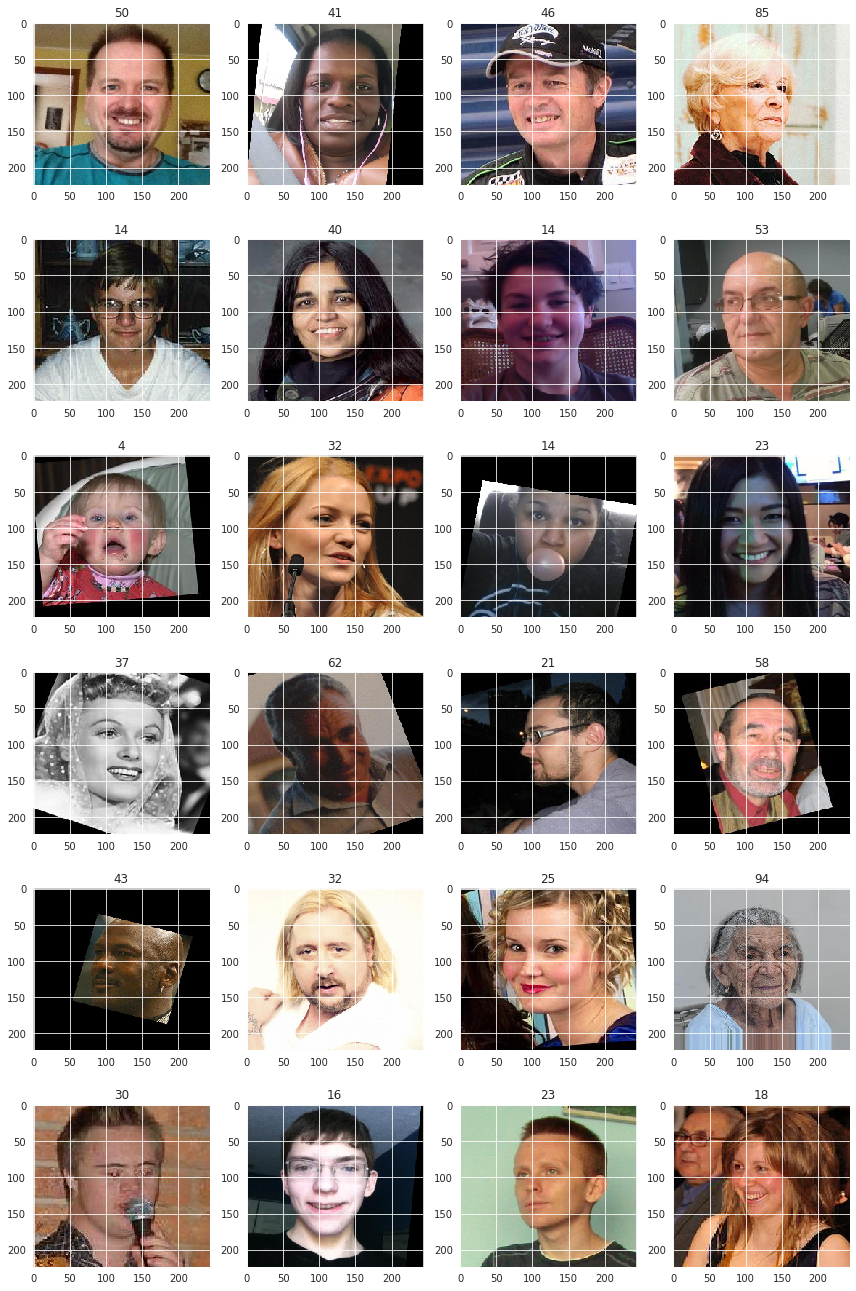

In [8]:
def show_images(batch, predictions=None):
    fig = plt.figure(figsize=(12,24))
    
    for i in range(24):
        fig.add_subplot(8,4, i+1)
        plt.imshow(batch[0][i])
        title = batch[1][i]
        if predictions is not None:
            title = f'gt: {title}, prediction: {round(predictions[i])}'
        plt.title(title)
        
    fig.tight_layout()

show_images(next(data_flow))

### Findings

- This is a regression task.
- We need the final layer with only one neuron cause it has to return one single value as output. I am going to add it to the backbone of ResNet50 by adding a Dense layer.
- Since we don't need negative values to be computed I am going to use 'ReLu' activation to transform those values in zeros.
- The suitable loss function is 'MSE' and the metric we are going to use is 'MAE' it should be less then 8.

## Modelling

In [9]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [10]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split = .25,
        rescale = 1./255)
    train_data_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,244),
        batch_size = 16,
        class_mode = 'raw',
        subset='training',
        seed = 12345)
        
    
    return train_gen_flow

Answer: applying augmentation, gives back a less MAE value. That's why I won't.

In [11]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split = .25,
        rescale = 1./255)
    test_data_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,244),
        batch_size = 16,
        class_mode = 'raw',
        subset='validation',
        seed = 12345)
    
    return test_gen_flow

In [12]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    backbone = ResNet50(weights='imagenet',
                       input_shape=input_shape,
                       include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.00025)
    model.compile(optimizer=optimizer, loss = 'mse', metrics=['mae'])
    
    return model

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=29,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if step_per_epoch is None:
        step_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
             epochs = epochs,
             validation_data=test_data,
             batch_size=batch_size,
             steps_per_epoch=steps_per_epoch,
             validation_steps = validation_steps,
             verbose=1)
    
    return model

## Prepare the Script to Run on the GPU Platform

In [14]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Train for 356 steps, validate for 119 steps\
Epoch 1/29\
2021-07-22 13:50:45.795361: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10\
2021-07-22 13:50:46.078498: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7\
356/356 - 45s - loss: 185.5438 - mae: 10.1316 - val_loss: 409.6900 - val_mae: 15.\
Epoch 2/29\
356/356 - 37s - loss: 92.4636 - mae: 7.2383 - val_loss: 163.8210 - val_mae: 9.8725\
Epoch 3/29\
356/356 - 38s - loss: 58.3541 - mae: 5.8983 - val_loss: 114.8840 - val_mae: 8.1869\
Epoch 4/29\
356/356 - 38s - loss: 35.4366 - mae: 4.6185 - val_loss: 80.9308 - val_mae: 6.7085\
Epoch 5/29\
356/356 - 37s - loss: 24.7770 - mae: 3.7921 - val_loss: 79.9232 - val_mae: 6.8614\
Epoch 6/29\
356/356 - 37s - loss: 17.7439 - mae: 3.2320 - val_loss: 98.5480 - val_mae: 7.2196\
Epoch 7/29\
356/356 - 37s - loss: 14.5933 - mae: 2.9475 - val_loss: 70.7268 - val_mae: 6.3024\
Epoch 8/29\
356/356 - 37s - loss: 14.8196 - mae: 2.9326 - val_loss: 71.9305 - val_mae: 6.3556\
Epoch 9/29\
356/356 - 38s - loss: 14.9091 - mae: 2.9338 - val_loss: 78.4009 - val_mae: 6.8505\
Epoch 10/29\
356/356 - 38s - loss: 13.1682 - mae: 2.7679 - val_loss: 72.5286 - val_mae: 6.3034\
Epoch 11/29\
356/356 - 38s - loss: 14.2221 - mae: 2.8717 - val_loss: 80.2753 - val_mae: 6.7456\
Epoch 12/29\
356/356 - 37s - loss: 14.6156 - mae: 2.8886 - val_loss: 78.9146 - val_mae: 6.5796\
Epoch 13/29\
356/356 - 38s - loss: 12.9957 - mae: 2.7320 - val_loss: 72.9162 - val_mae: 6.4381\
Epoch 14/29\
356/356 - 37s - loss: 10.5154 - mae: 2.4850 - val_loss: 72.7064 - val_mae: 6.3392\
Epoch 15/29\
356/356 - 37s - loss: 8.9872 - mae: 2.2824 - val_loss: 69.2501 - val_mae: 6.0371\
Epoch 16/29\
356/356 - 37s - loss: 7.7286 - mae: 2.0973 - val_loss: 77.2039 - val_mae: 6.7151\
Epoch 17/29\
356/356 - 37s - loss: 8.8071 - mae: 2.2553 - val_loss: 121.5123 - val_mae: 8.0337\
Epoch 18/29\
356/356 - 38s - loss: 23.3677 - mae: 3.6460 - val_loss: 115.0686 - val_mae: 8.3702\
Epoch 19/29\
356/356 - 38s - loss: 23.0183 - mae: 3.6145 - val_loss: 81.9440 - val_mae: 6.9290\
Epoch 20/29\
356/356 - 38s - loss: 11.9603 - mae: 2.5756 - val_loss: 73.5473 - val_mae: 6.2886\
Epoch 21/29\
356/356 - 37s - loss: 5.7950 - mae: 1.7971 - val_loss: 67.1093 - val_mae: 6.0874\
Epoch 22/29\
356/356 - 37s - loss: 3.2634 - mae: 1.3526 - val_loss: 68.1328 - val_mae: 6.1040\
Epoch 23/29\
356/356 - 38s - loss: 2.4278 - mae: 1.1653 - val_loss: 66.3813 - val_mae: 6.0967\
Epoch 24/29\
356/356 - 38s - loss: 2.6048 - mae: 1.2062 - val_loss: 68.4044 - val_mae: 6.2353\
Epoch 25/29\
356/356 - 37s - loss: 3.3497 - mae: 1.3657 - val_loss: 68.4114 - val_mae: 6.2043\
Epoch 26/29\
356/356 - 38s - loss: 5.0504 - mae: 1.6865 - val_loss: 65.6572 - val_mae: 6.0358\
Epoch 27/29\
356/356 - 38s - loss: 7.0184 - mae: 2.0083 - val_loss: 70.4858 - val_mae: 6.2259\
Epoch 28/29\
356/356 - 37s - loss: 8.7682 - mae: 2.2477 - val_loss: 78.1103 - val_mae: 6.5730\
Epoch 29/29\
356/356 - 38s - loss: 9.7636 - mae: 2.3855 - val_loss: 68.7942 - val_mae: 6.1227

## Conclusions

I trained a Neural Network to recognize the age of a person from photos. The model choosen was the backbone of a ResNet50, specified activation as 'relu' to transform negative values into 0 and added a final layer with one neuron to return a single output obtained by the regression. Loss function choosen was 'mse' the metric was 'mae', I didn't used any kind of augmentation while defining training and testing set. The choosen batch size was 16 and the learning r=0.00025.



Recently, the Macau district in China has introduced ATM’s that are capable of reading the user’s face.\
This negates the need for cards and pin numbers.\
If proved to be successful it could lead to the end of paying with plastic.\
Cameras driven by Artificial Neural Networks recognize customer’s face.\
The system then makes product suggestions based on the customer’s past history and information.